In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants

In [63]:
redled_voltages = pd.read_csv('data/voltage/redled.csv')
yellowled_voltages = pd.read_csv('data/voltage/yellowled.csv')
greenled_voltages = pd.read_csv('data/voltage/greenled.csv')
blueled_voltages = pd.read_csv('data/voltage/blueled.csv')

redled_voltages.head()

,PowerSupply voltage,Gemeten Voltage,Gemeten Ampere,Verschil in Ampere,LED voltage
0,1.72,9,4,NaN,1.71
1,1.73,10,5,1.0,1.72
2,1.74,15,7,2.0,1.73
3,1.75,19,8,1.0,1.73
4,1.76,21,10,2.0,1.74


In [64]:
voltages = []
def error(data_volt):
    error_ledvoltage = []
    for i in range(len(data_volt['LED voltage'])):
    # formule = afgeleide
        error_v = np.sqrt((0.003/220)**2 + (-data_volt['LED voltage'][i] * 5 / 220**2)**2)
        error_ledvoltage.append(error_v)



def fit (data_volt):
    verschil = np.array(data_volt['Verschil in Ampere'])[-1] - 1

    # vind de stabiele punt
    for _ in range(len(data_volt['Verschil in Ampere'])):
        if data_volt['Verschil in Ampere'][_] > verschil:
            stabiel = _
            break

    m, q = np.polyfit(data_volt['LED voltage'][stabiel:], data_volt['Gemeten Ampere'][stabiel:]/1000, 1)

    # vind de nulpunt en waar de nulpunt voorkomt
    nulpunt = round(-q / m, 3)
    voltages.append(nulpunt)
    
    index = data_volt['LED voltage'][round(data_volt['LED voltage'], 1) == round(nulpunt, 1)]
    return m, q, nulpunt, index.index[0], stabiel



def grafiek(data_volt, kleur, min_index, m, q, errors, nulpunt):
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # Eereste graads fit 
    x = np.linspace(data_volt['LED voltage'][min_index], np.array(data_volt['LED voltage'])[-1], 100)
    y = m * x + q
    ax.plot(x, y, label='Eerste Graad fit')

    # data
    ax.errorbar(
        data_volt['LED voltage'],
        data_volt['Gemeten Ampere']/1000,
        yerr=errors,
        linestyle='',
        color='black',
        ecolor='black',
        marker="o",
        markersize=5,
        capsize=1,
        capthick=1.6,
        linewidth=1.6,
        label=f'{kleur} LED'
    )

    # nulpunt
    plt.axvline(nulpunt, color="red", linestyle="--", label=f'{kleur} LED Minimum Spanning: {round(nulpunt, 2)}V')
    
    plt.title('Stroom (A) in Functie van de Spanning (V)')
    ax.set_xlabel('Spanning (V)')
    ax.set_ylabel('Stroon (A)')
    plt.legend()
    plt.grid(True)
    plt.show()

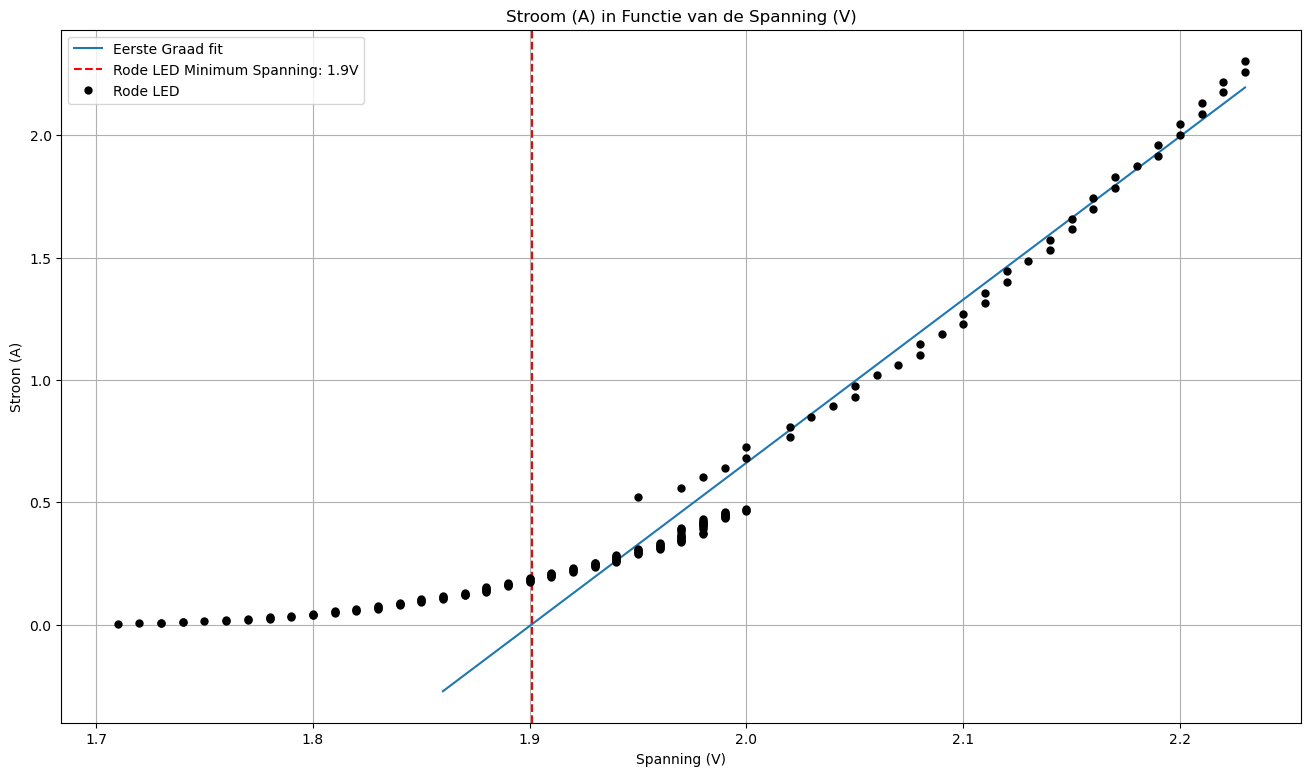

In [65]:
# Rode LED
error_redled = error(redled_voltages)
redled_m, redled_q, redled_minimum, redled_min_index,  redled_stabiel = fit(redled_voltages)
grafiek(redled_voltages, 'Rode', redled_min_index, redled_m, redled_q, error_redled, redled_minimum)

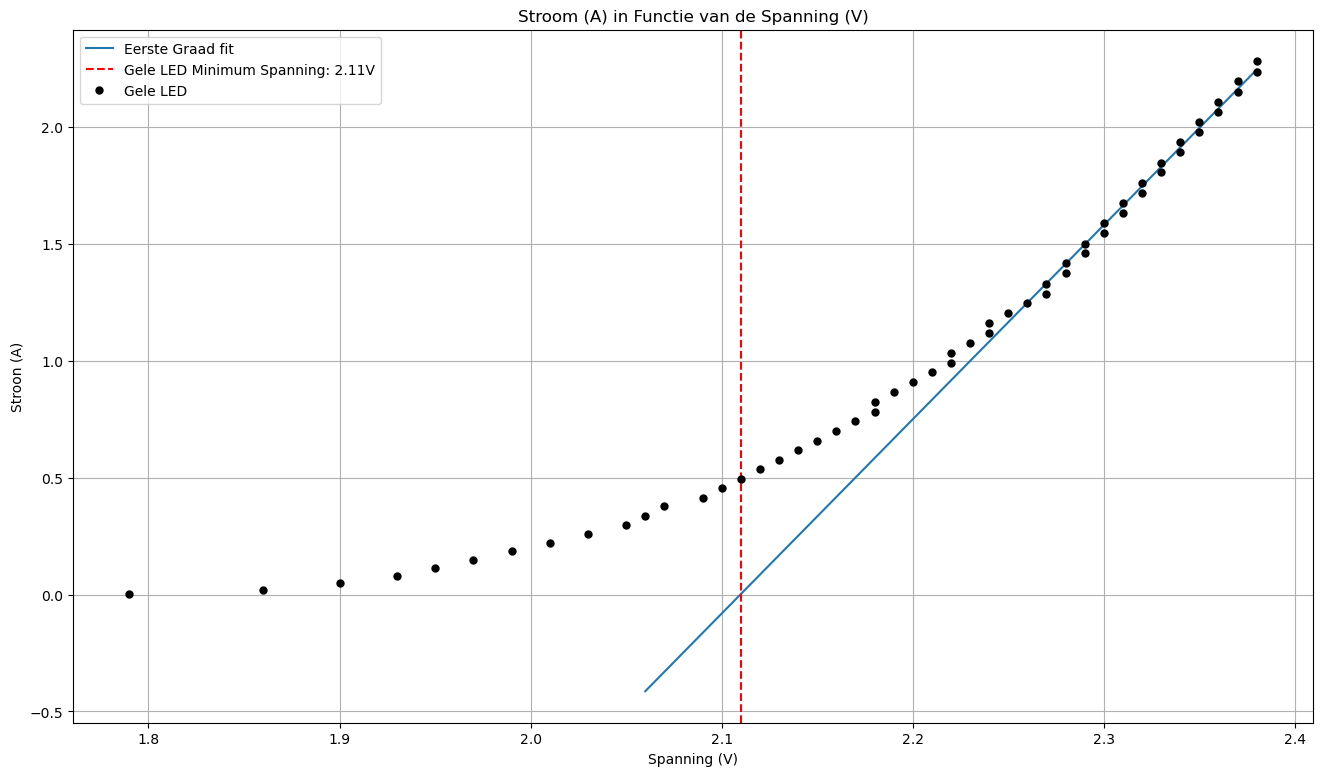

In [66]:
# Gele LED
error_yellowled = error(yellowled_voltages)
yellowled_m, yellowled_q, yellowled_minimum, yellowled_min_index, yellowled_stabiel = fit(yellowled_voltages)
grafiek(yellowled_voltages, 'Gele', yellowled_min_index, yellowled_m, yellowled_q, error_yellowled, yellowled_minimum)

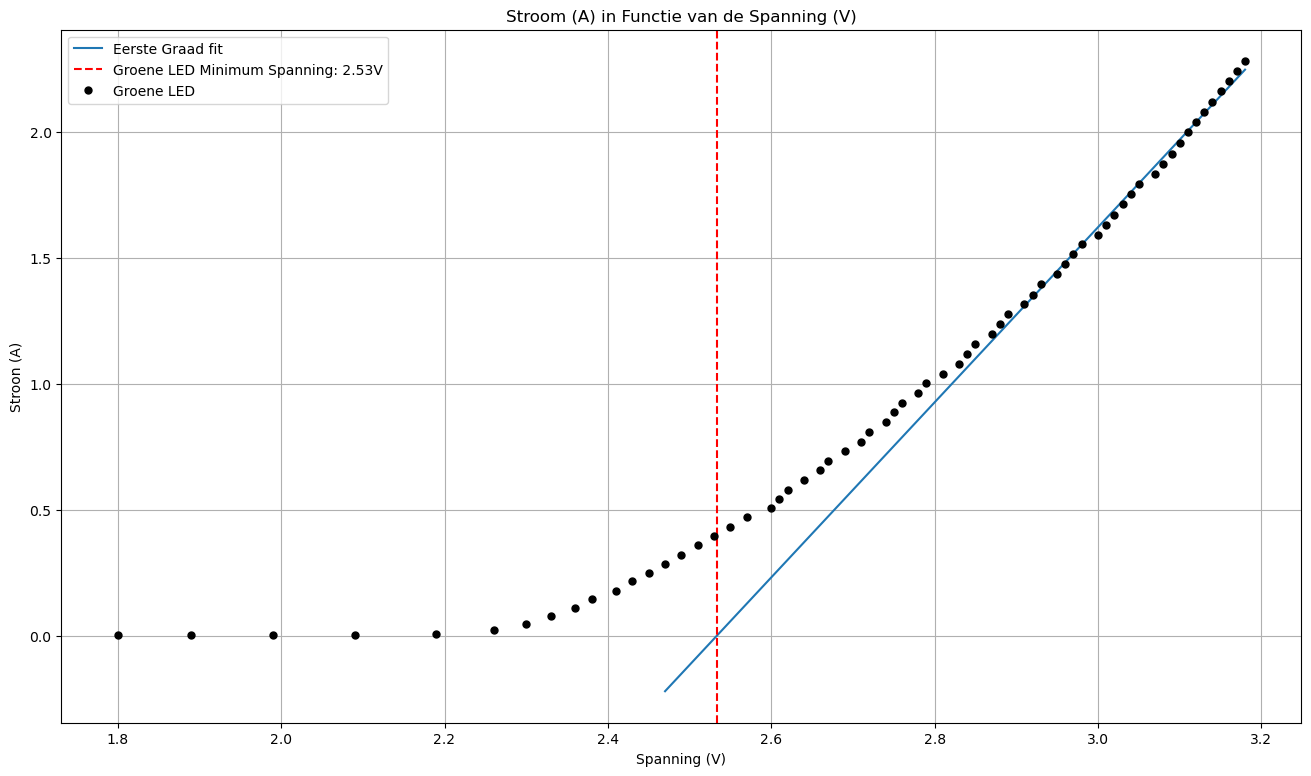

In [67]:
# Groene LED
error_greenled = error(greenled_voltages)
greenled_m, greenled_q, greenled_minimum, greenled_min_index, greenled_stabiel = fit(greenled_voltages)
grafiek(greenled_voltages, 'Groene', greenled_min_index, greenled_m, greenled_q, error_greenled, greenled_minimum)

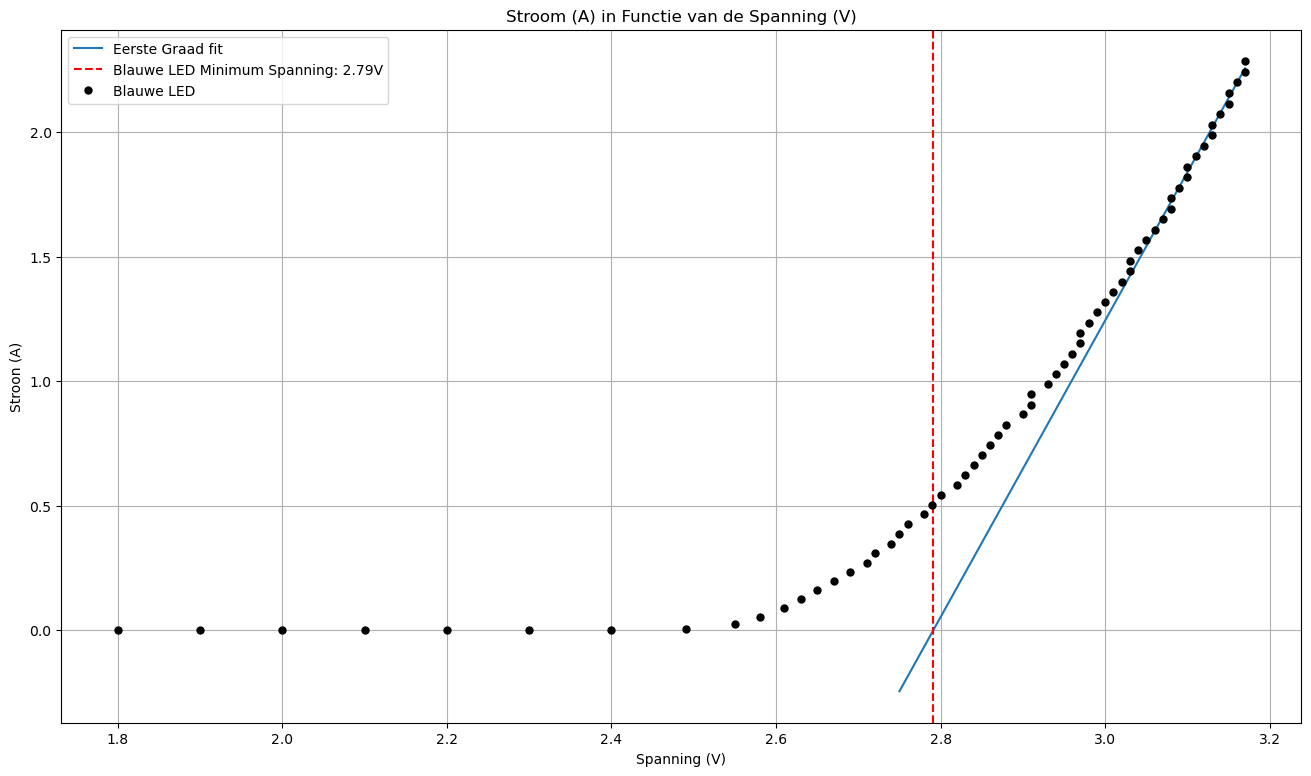

In [68]:
# Blauwe LED
error_blueled = error(blueled_voltages)
blueled_m, blueled_q, blueled_minimum, blueled_min_index, blueled_stabiel = fit(blueled_voltages)
grafiek(blueled_voltages, 'Blauwe', blueled_min_index, blueled_m, blueled_q, error_blueled, blueled_minimum)

In [69]:
redled_lambda = pd.read_csv('data/golflengte/red.txt', sep='\t', decimal=',', names=['golflengte', 'intensiteit'], skiprows=1)
yellowled_lambda = pd.read_csv('data/golflengte/yellow.txt', sep='\t', decimal=',', names=['golflengte', 'intensiteit'], skiprows=1)
greenled_lambda = pd.read_csv('data/golflengte/green.txt', sep='\t', decimal=',', names=['golflengte', 'intensiteit'], skiprows=1)
blueled_lambda = pd.read_csv('data/golflengte/blue.txt', sep='\t', decimal=',', names=['golflengte', 'intensiteit'], skiprows=1)

redled_lambda

,golflengte,intensiteit
0,338.317,1502.0
1,338.772,1500.2
2,339.228,1497.2
3,339.683,1501.2
4,340.139,1502.4
...,...,...
1018,822.164,1501.5
1019,822.657,1501.6
1020,823.150,1500.3
1021,823.643,1502.2


In [70]:
lambdas = []
def led_golflengte(data_lambda):
    # bepaal de peaken
    peak = data_lambda['intensiteit'].idxmax()
    lambda_peak = data_lambda.loc[peak, 'golflengte']
    intensiteit_peak = data_lambda.loc[peak, 'intensiteit']

    # neem de grootste helling aan de linkerkant (tangent methode)
    data_links = data_lambda.iloc[:peak].copy()
    data_links['helling'] = np.gradient(data_links['intensiteit'], data_links['golflengte'])

    # zoek de sterkste helling
    steilste = data_links['helling'].idxmax()
    x0 = data_links.loc[steilste, 'golflengte']
    y0 = data_links.loc[steilste, 'intensiteit']
    m = data_links.loc[steilste, 'helling']

    # corrigeer de data aan (ongeveer 1500 zie data)
    correctie = data_lambda['intensiteit'].iloc[:10].mean()

    # bereken de nulpunt
    juiste_lambda = x0 - (y0 - correctie) / m
    lambdas.append(juiste_lambda)

    return round(lambda_peak, 1), round(juiste_lambda, 1), x0, y0, m, correctie

def grafiek_lambda(data_lambda, kleur, couleur, juiste_lambda, x0, y0, m, correctie):
    fig, ax = plt.subplots(figsize=(16, 9))

    ax.plot(data_lambda['golflengte'], data_lambda['intensiteit'], label=f'{kleur} LED spectrum', color=couleur)

    # tangent lijn
    x_tan = np.linspace(juiste_lambda-1, x0+4, 100)
    y_tan = m * (x_tan - x0) + y0
    ax.plot(x_tan, y_tan, '--', color='black', linewidth=1, label='tangent')
    ax.scatter([juiste_lambda], [correctie], color='black', zorder=5, label=f'Tangent-intercept: {round(juiste_lambda, 1)}nm')

    # grafiek
    plt.axhline(y=1500, color='gray', linestyle=':', label='Achtergrond Ruis')
    plt.title('Bepaling van de Golflengtevia de "Raaklijn-methode"')
    plt.xlabel('Golflengte(nm)')
    plt.ylabel('Intensiteit (a.u.)')
    plt.legend()
    plt.grid()
    plt.show()

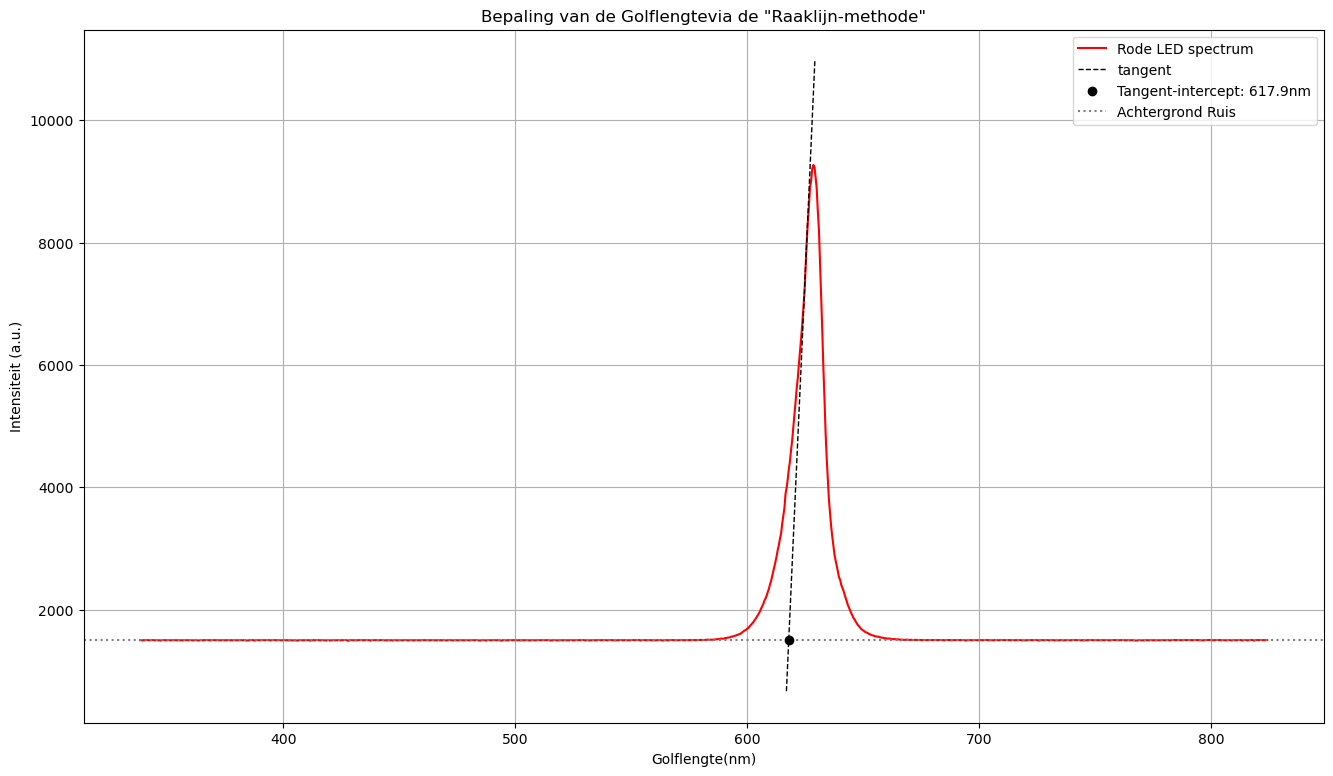

In [71]:
# Rode LED
redled_peak, redled_golflengte, redled_x, redled_y, redled_m, redled_correctie = led_golflengte(redled_lambda)
grafiek_lambda(redled_lambda, 'Rode', 'red', redled_golflengte, redled_x, redled_y, redled_m, redled_correctie)

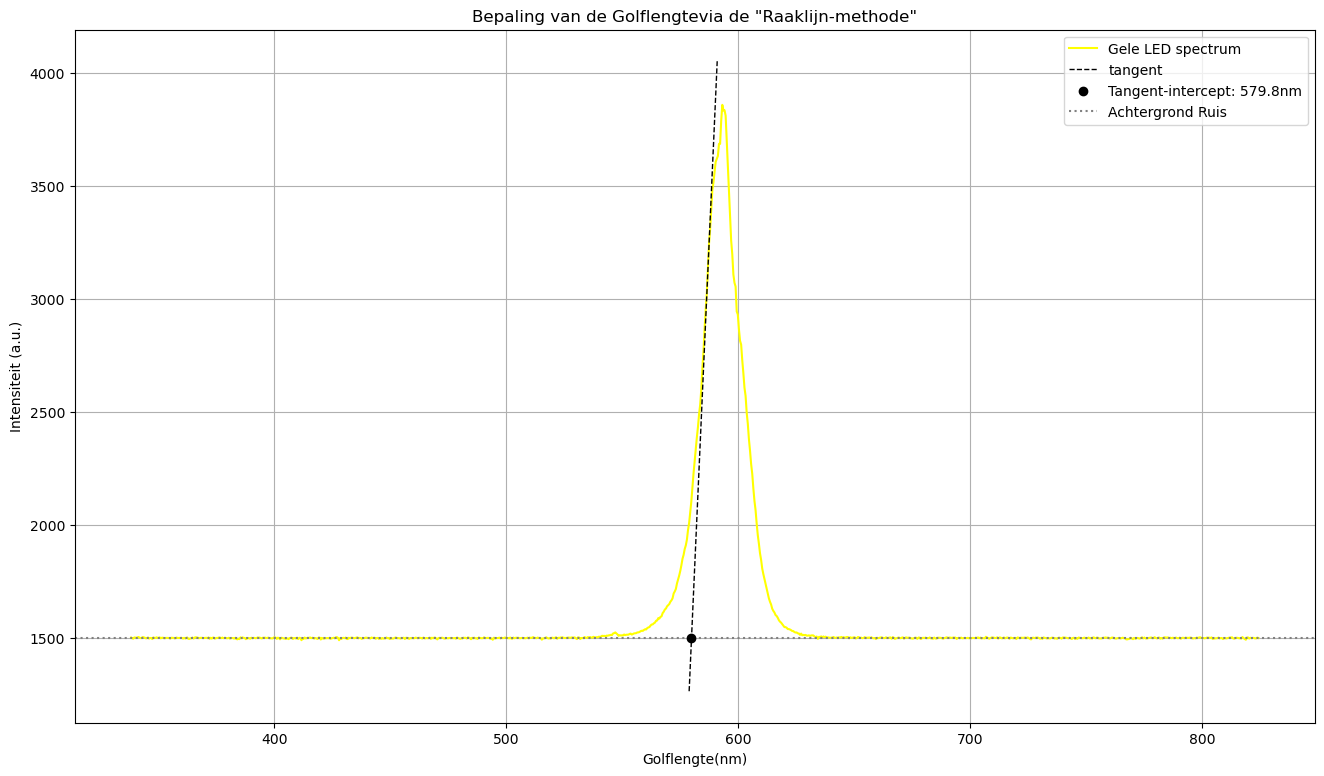

In [72]:
# Gele LED
yellowled_peak, yellowled_golflengte, yellowled_x, yellowled_y, yellowled_m, yellowled_correctie = led_golflengte(yellowled_lambda)
grafiek_lambda(yellowled_lambda, 'Gele', 'yellow', yellowled_golflengte, yellowled_x, yellowled_y, yellowled_m, yellowled_correctie)

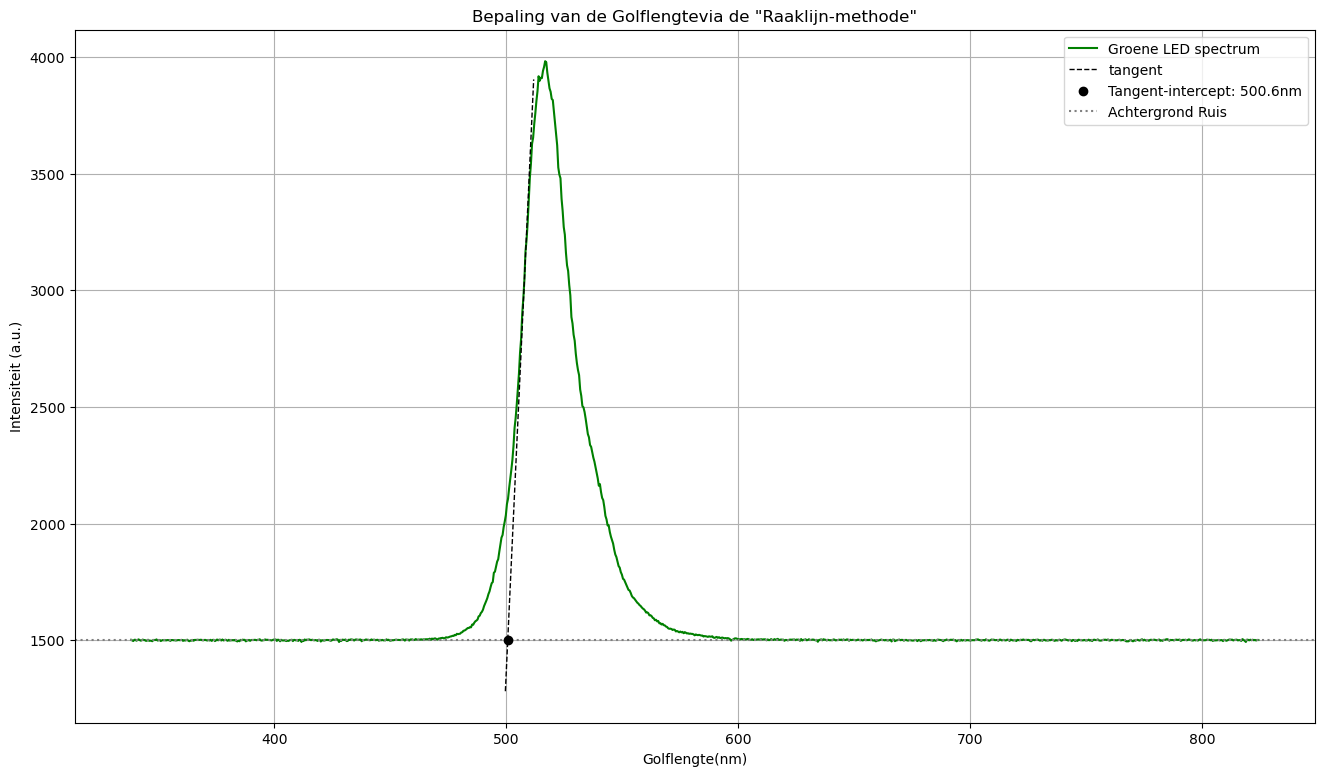

In [73]:
# Groene LED
greenled_peak, greenled_golflengte, greenled_x, greenled_y, greenled_m, greenled_correctie = led_golflengte(greenled_lambda)
grafiek_lambda(greenled_lambda, 'Groene', 'green', greenled_golflengte, greenled_x, greenled_y, greenled_m, greenled_correctie)

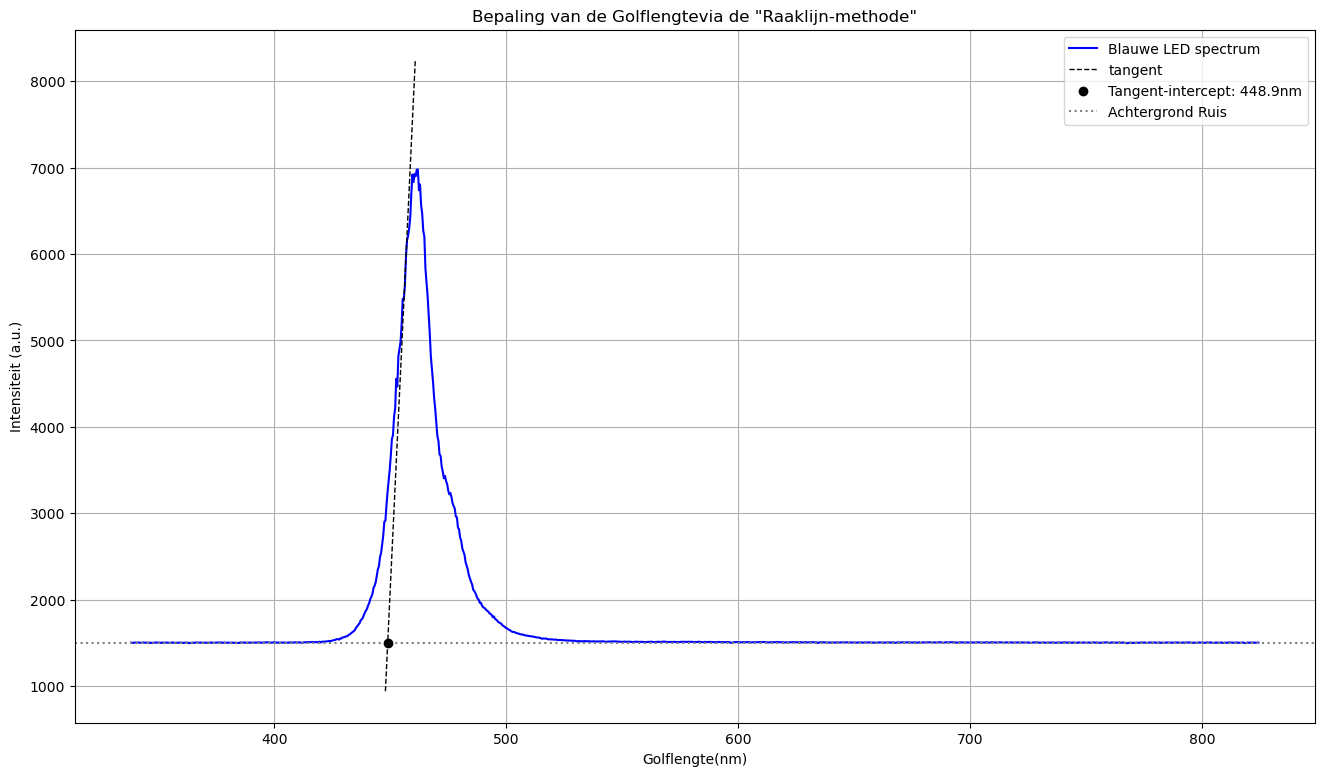

In [74]:
# Blauwe LED
blueled_peak, blueled_golflengte, blueled_x, blueled_y, blueled_m, blueled_correctie = led_golflengte(blueled_lambda)
grafiek_lambda(blueled_lambda, 'Blauwe', 'blue', blueled_golflengte, blueled_x, blueled_y, blueled_m, blueled_correctie)

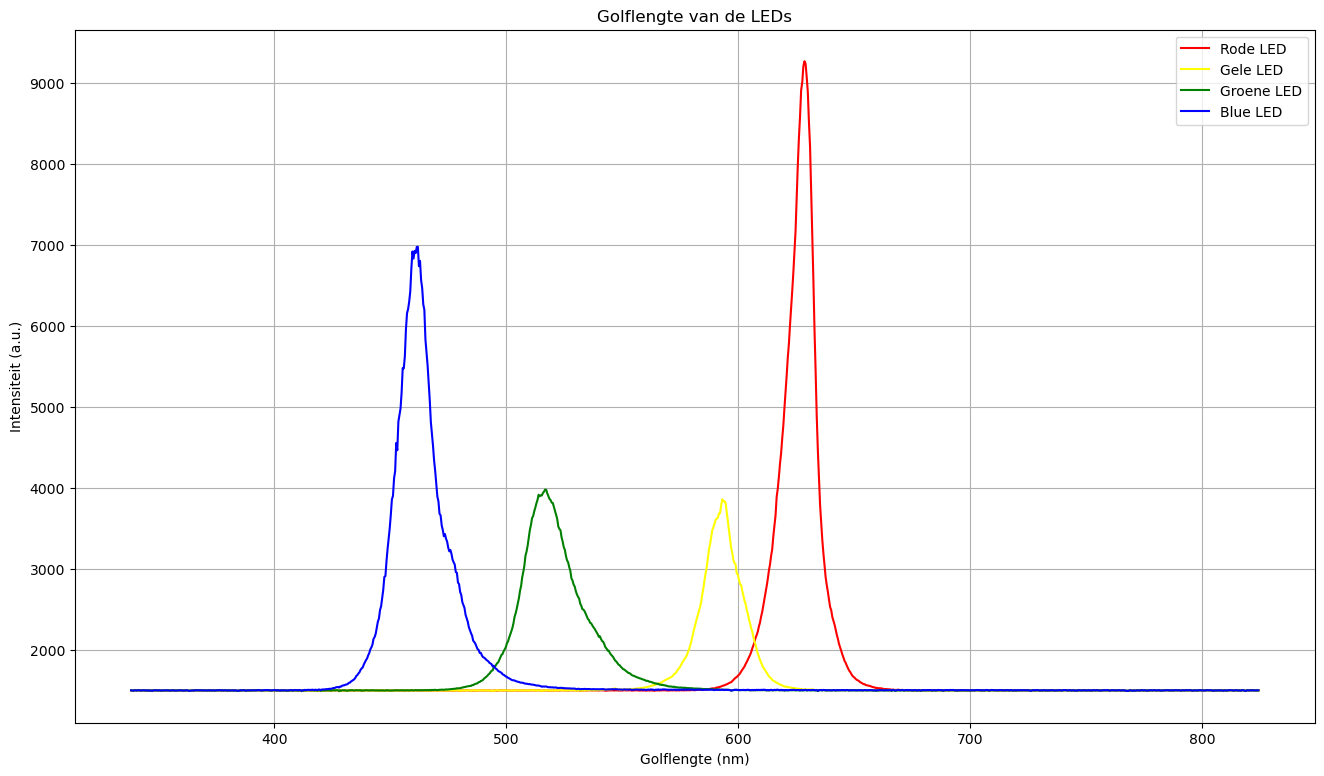

In [75]:
# alle kleuren samen
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(redled_lambda['golflengte'], redled_lambda['intensiteit'], color='red', label='Rode LED')
ax.plot(yellowled_lambda['golflengte'], yellowled_lambda['intensiteit'], color='yellow', label='Gele LED')
ax.plot(greenled_lambda['golflengte'], greenled_lambda['intensiteit'], color='green', label='Groene LED')
ax.plot(blueled_lambda['golflengte'], blueled_lambda['intensiteit'], color='blue', label='Blue LED')

plt.title('Golflengte van de LEDs')
plt.xlabel('Golflengte (nm)')
plt.ylabel('Intensiteit (a.u.)')
plt.legend()
plt.grid()
plt.show()

In [76]:
c = constants.c
elec = constants.elementary_charge
def planckconstante(golflengte, voltage):
    return golflengte * voltage * elec * 10**-9/ c

In [77]:
constantes = []
accuraat = []
for kleur in range(len(lambdas)):
    planck = planckconstante(lambdas[kleur], voltages[kleur])
    constantes.append(planck)
    accuraat.append(round(planck / (constants.Planck), 2)*100)

In [78]:
planck = sum(constantes)/4 # neem gemiddelde
percentage = round(planck / (6.626*10**-34), 3)*100 # neem gemiddelde

In [81]:
print(f'De experimenteel bepaalde Planck-Constante is: {(planck)*10**34:.3f}e-34Js. Het komt {percentage}% overeen met de echte waarde')

De experimenteel bepaalde Planck-Constante is: 6.573e-34Js. Het komt 99.2% overeen met de echte waarde
